# Overfitting and Regularization

## Imports

In [460]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [461]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [462]:
set_config(display='diagram')
sns.set(font_scale=1.1)

## Settings

In [463]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [464]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

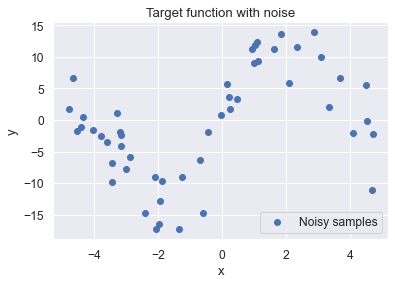

In [465]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y, 'Target function with noise')

### Split

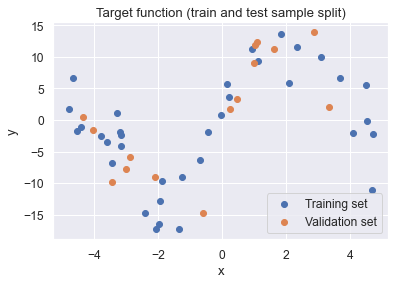

In [466]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, 'Target function (train and test sample split)', label='Training set')
plot_scatter(X_valid, y_valid, 'Target function (train and test sample split)', label='Validation set')

In [467]:
print(f'y_train set:\n {y_train}')

y_train set:
 [ -1.10771616   0.84986647  -9.62110024   3.70972424  -2.36319095
   5.83708039 -16.53330524  -1.8815588  -11.1506254    1.0883081
  -9.05957818 -14.72254274   5.71746212   5.48508317  -6.81897956
  -1.80751907  -2.14124891 -12.83476672  -0.09034969  -3.48222266
  11.50001273  -2.03019037  10.03142993 -17.18409407  -2.48182149
   1.67461593 -17.32081894  -6.32825039  -4.15121484   9.31494651
   6.5817456    6.58351686  -1.83803375  11.27589865  13.68530977]


### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [468]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [469]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

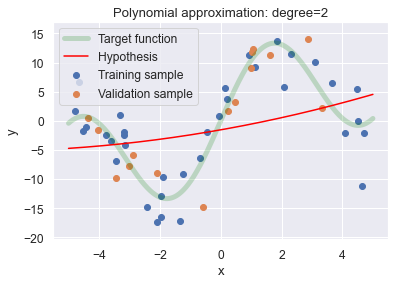

In [470]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

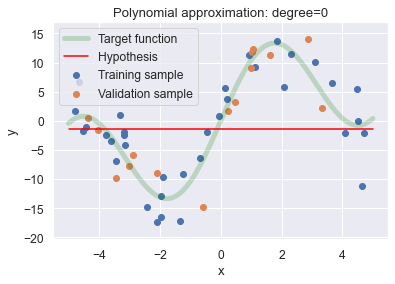

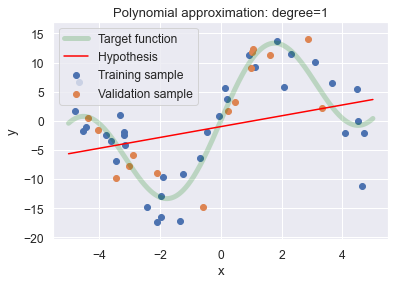

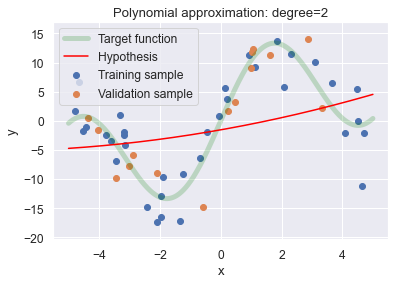

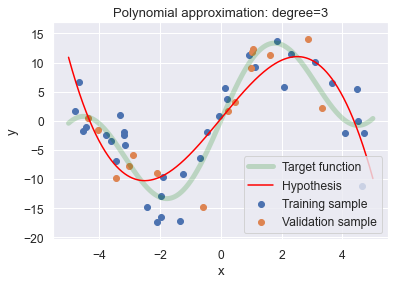

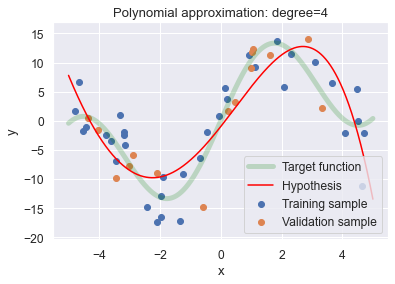

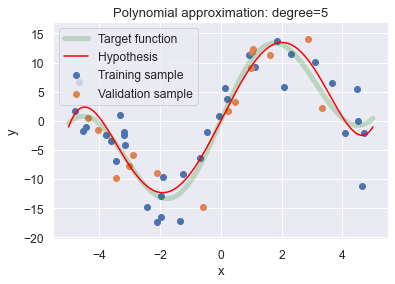

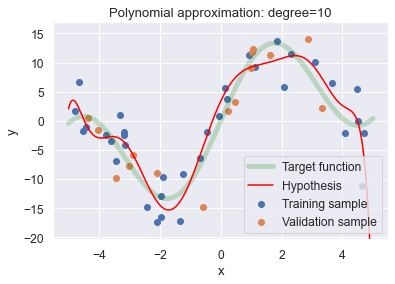

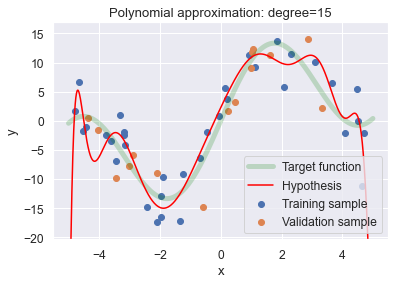

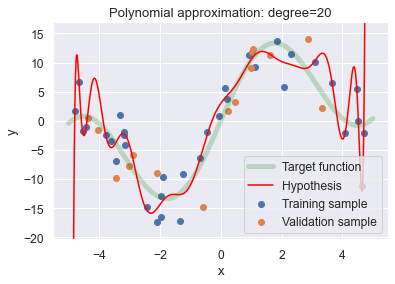

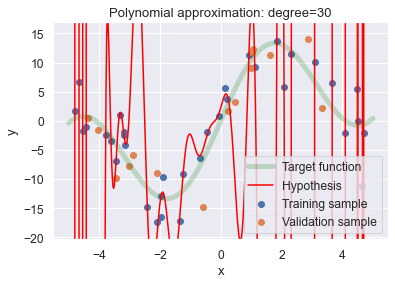

In [471]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20, 30]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

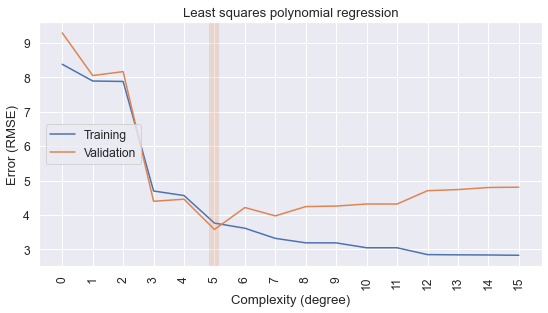

In [472]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [473]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

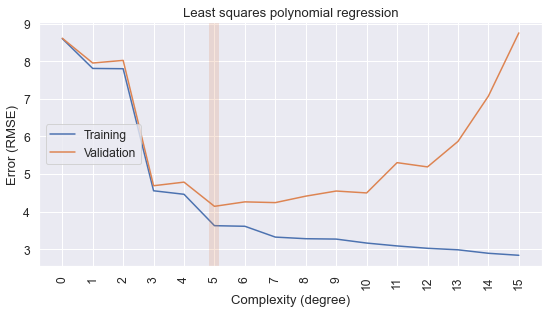

In [474]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [475]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

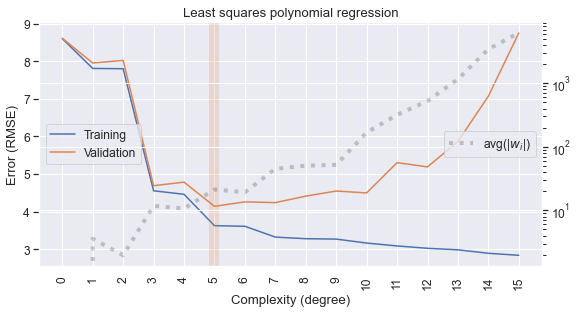

In [476]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

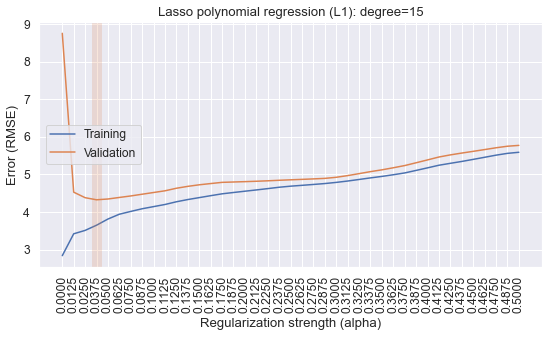

In [477]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

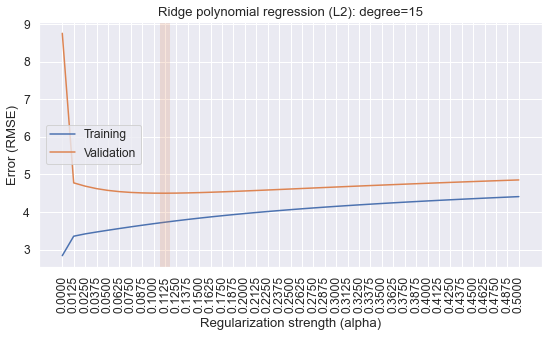

In [478]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [479]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

- Forming X, Y sets and spliting them on 70/30 proporion test and train sets. Show relationships on target and every featury among both sets

In [480]:
X = pd.DataFrame(data.data, columns = ['age','sex', 'bmi', 'dp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'])
Y = data.target

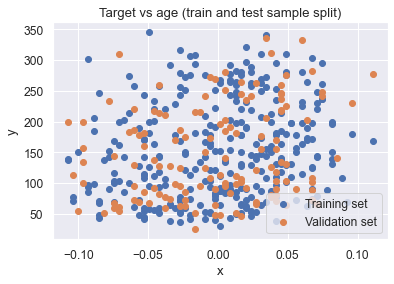

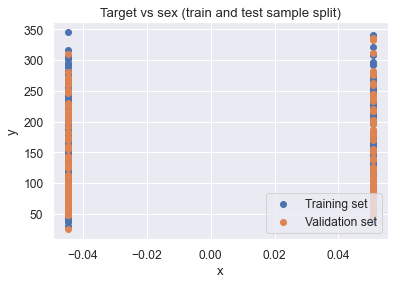

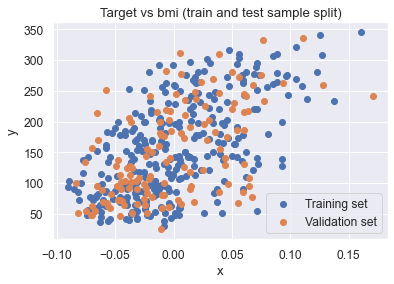

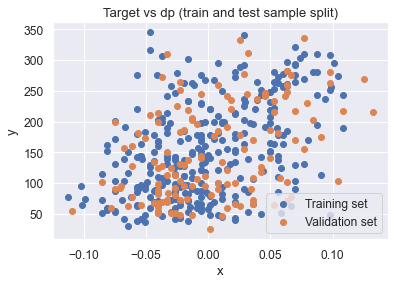

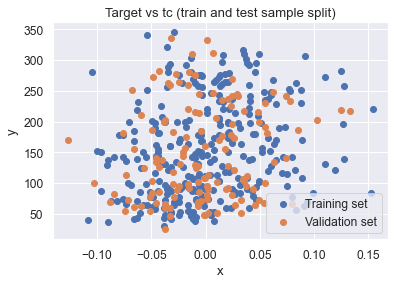

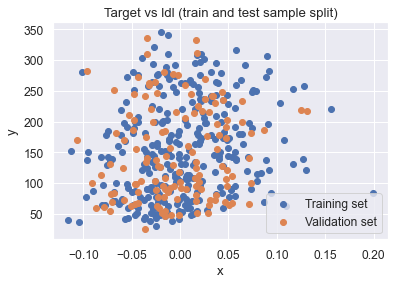

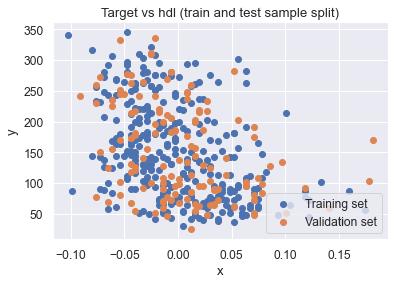

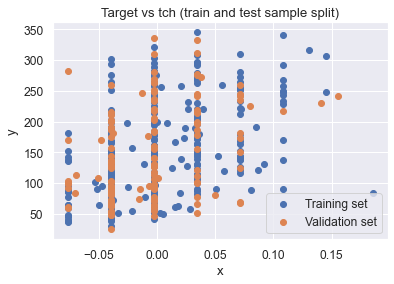

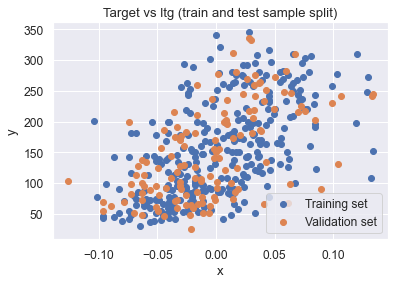

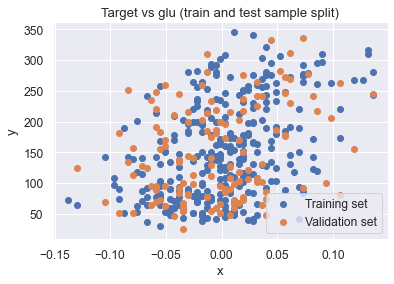

In [481]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3)
for feature in X_train.columns.to_list():
    plot_scatter(X_train[feature], y_train, f'Target vs {feature} (train and test sample split)', label='Training set')
    plot_scatter(X_valid[feature], y_valid, f'Target vs {feature} (train and test sample split)', label='Validation set')
    plt.show()

As we can see, target haven't got high linear dependency on any of features (looking at train set). In common, all dependencies with target directly proportional, only 'hdi' dependency is inversely propotional. 

- Have a brief look at given data. Show correlation heatmap 

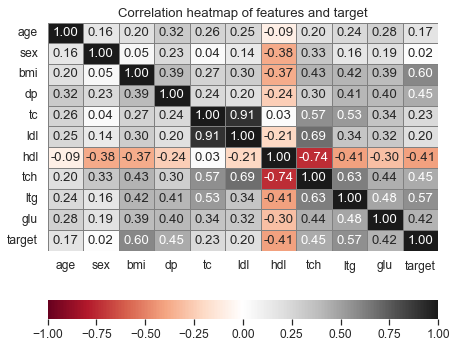

In [482]:
corr_mat = X_train.copy()
corr_mat['target'] = y_train
plt.figure(figsize=(7,6))
sns.heatmap(corr_mat.corr(), annot=True, cbar_kws= {'orientation': 'horizontal'}, 
            vmin=-1, vmax=1, center= 0, cmap= 'RdGy', fmt = '.2f', linewidths=0.5, linecolor='grey')
plt.title('Correlation heatmap of features and target')
plt.show()

As we can see, target have medium and low correlation with each of features

Most correlated feature with target: 'bmi'(0,61); Least corelated feature with target: 'sex' (0,07)

Also, there are highly correlated feature pairs: 'ldl' and 'tc', 'tch' and 'hdl'. It shows multicillinearity is take place in given train set of features.    

 - Make and fit model with different degrees of polinomial features. Take from 1 to 9 degrees (for less time comsumption). 
 
 Compute rmse and show plot for train and validation error.

In [483]:
rmse_train, rmse_valid, L2 = [], [], []
Deg = np.linspace(1, 9, 0+9, dtype=int)
for degree in Deg:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid)) 
    L2.append((np.square(make_model(degree).fit(X_train, y_train)['reg'].coef_).sum())**0.5)

In [484]:
df_rmse = pd.DataFrame({'rmse_train' : rmse_train, 'rmse_valid' : rmse_valid, 'L2' : L2}, index = Deg)
print(f'rsme data:\n{df_rmse}')

rsme data:
     rmse_train  rmse_valid            L2
1  5.258087e+01   55.911298  6.312325e+01
2  4.813776e+01   61.891088  2.818604e+14
3  1.867280e+01  825.589040  1.899838e+06
4  1.552359e-12  358.950216  4.965537e+02
5  1.405081e-12  255.061368  2.636666e+02
6  2.427650e-12  291.051340  2.011612e+02
7  4.177183e-12  259.958927  1.693384e+02
8  5.930365e-12  374.455411  1.503477e+02
9  1.185794e-11  396.902942  1.376016e+02


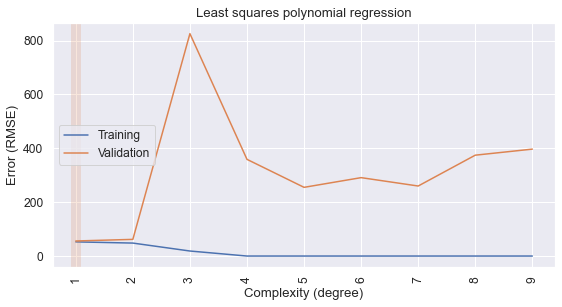

Optimal degree: 1


In [485]:
plot_fitting_graph(Deg, rmse_train, rmse_valid, 
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

print(f'Optimal degree: {Deg[np.argmin(rmse_valid)]}')

 ### Findings on excercise 1:
 We applied model for diabetes dataset with polynomial features with degrees from 1 to 9. 
 
 **We find optimal degree is 1** (linear regression). The fit is good for both the training and the validation set. 
 
 **Model overfitted**  with degree of polynomial features 2 and more. We can see it by plot and high value of rmse_valid (from ~61 to ~825) and L2-norm. Fit for the validation set gets worse. The linear model coefficients become extremely large.
 


### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

- Make and fit a model with polynomial feature of 15 degree.

From previous task we know that the more degree, the more model overfitted

To make calculation less complex, choose columns for polinomial transform. Rest will be unchanged. I choose by correlation with target, 3 features with correlation > 0 ('bmi, 'dp', 'age') and 1 feature with correlation < 0 ('hdl')  

In [486]:
X_pol = X[['bmi', 'dp', 'age', 'hdl']]
restcol = list(X.columns)
for col in X_pol:
    restcol.remove(col)
X_unch = X[restcol]   
X_polfeat = PolynomialFeatures(degree=15, include_bias=False).fit_transform(X=X_pol)
X_polifeat = pd.DataFrame(X_polfeat)
X_poly = pd.concat([X_unch, X_polifeat], axis = 1)


Linear polinomial regression with degree 15

In [487]:
rmse_train_, rmse_valid_, l2, avg_coef_ = [], [], [], []
results = cross_validate(LinearRegression(fit_intercept=True), 
                             X_poly, Y, cv=3,
                             scoring=('neg_root_mean_squared_error', 'r2'),
                             return_train_score=True, return_estimator=True,)
rmse_train_.append(-np.mean(results['train_neg_root_mean_squared_error']))
rmse_valid_.append(-np.mean(results['test_neg_root_mean_squared_error']))
l2.append(np.mean(results['train_r2']))
avg_coef_.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))   

#### L1

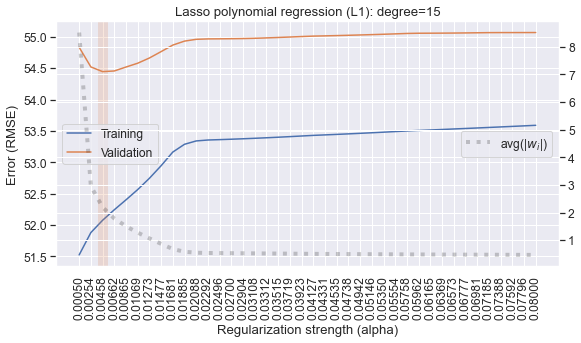

In [489]:
rmse_train_l1, rmse_valid_l1, l2, avg_coef_l1 = [], [], [], []
Alpas = np.linspace(0.0005, 0.08, 1 + 39)
for alpha in Alpas:    
    results = cross_validate(Lasso(alpha=alpha), 
                             X_poly, Y, cv=3,
                             scoring=('neg_root_mean_squared_error', 'r2'),
                             return_train_score=True, return_estimator=True,)
    rmse_train_l1.append(-np.mean(results['train_neg_root_mean_squared_error']))
    rmse_valid_l1.append(-np.mean(results['test_neg_root_mean_squared_error']))
    l2.append(np.mean(results['train_r2']))
    avg_coef_l1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))   
            
plot_fitting_graph(Alpas, rmse_train_l1, rmse_valid_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1, custom_label='avg(|$w_i$|)', custom_scale='linear',
                   title='Lasso polynomial regression (L1): degree=15')


In [490]:
print(f'Optimal alpa for L1 regularization: {Alpas[np.argmin(rmse_valid_l1)]}\nMean error: {min(rmse_valid_l1)}')

Optimal alpa for L1 regularization: 0.004576923076923077
Mean error: 54.44565338452059


#### L2

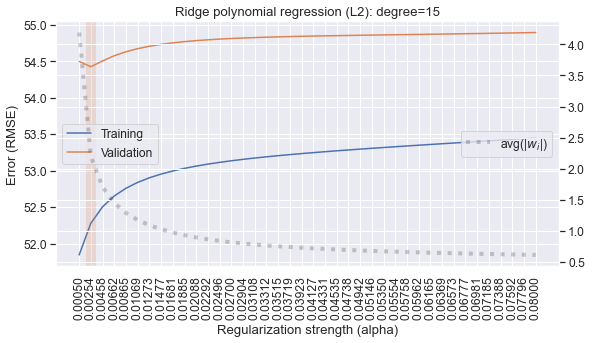

In [491]:
rmse_train_l2, rmse_valid_l2, l2, avg_coef_l2 = [], [], [], []
Alpas = np.linspace(0.0005, 0.08, 1 + 39)
for alpha in Alpas:    
    results = cross_validate(Ridge(alpha=alpha), 
                             X_poly, Y, cv=3,
                             scoring=('neg_root_mean_squared_error', 'r2'),
                             return_train_score=True, return_estimator=True,)
    rmse_train_l2.append(-np.mean(results['train_neg_root_mean_squared_error']))
    rmse_valid_l2.append(-np.mean(results['test_neg_root_mean_squared_error']))
    l2.append(np.mean(results['train_r2']))
    avg_coef_l2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))   
             
plot_fitting_graph(Alpas, rmse_train_l2, rmse_valid_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l2, custom_label='avg(|$w_i$|)', custom_scale='linear',
                   title='Ridge polynomial regression (L2): degree=15')


In [492]:
print(f'Optimal alpa for L2 regularization: {Alpas[np.argmin(rmse_valid_l2)]}\nMean error: {min(rmse_valid_l2)}')
avg_coef_l2[np.argmin(rmse_valid_l2)]

Optimal alpa for L2 regularization: 0.0025384615384615385
Mean error: 54.42498758798575


2.197600158223589

In [493]:
pd.DataFrame({'Alpa': ['-', Alpas[np.argmin(rmse_valid_l1)], Alpas[np.argmin(rmse_valid_l2)]], 
              'RMSE' : [min(rmse_valid), min(rmse_valid_l1), min(rmse_valid_l2)], 
              'Average coefficient' : [avg_coef_[0], avg_coef_l1[np.argmin(rmse_valid_l1)], avg_coef_l2[np.argmin(rmse_valid_l2)]]},
            index = ['No reg', 'L1', 'L2'])

,Alpa,RMSE,Average coefficient
No reg,-,55.911298,1.343394e+10
L1,0.004577,54.445653,2.193237e+00
L2,0.002538,54.424988,2.197600e+00


Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

### Summary

 ### Findings on excercise 2:
Regularized version of the model performs better, even in case of the heavily overfitting of origin model.

Making regularization model coefficient become significantly less, model become stable. RMSE of validation become less.

We can see that in given example Ridge and Lasso regularization have close parameters (RMSE and model coefficients). But optimal alpa (regularization strength) for Ridge is less, it mean that Ridge gain optimal parameters faster. 

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [494]:
avg_coef_1 = []
results = cross_validate(Lasso(alpha=Alpas[np.argmin(rmse_valid_l1)]), 
                             X_poly, Y, cv=3,
                             return_estimator=True,)
for model in results['estimator']:
    avg_coef_1.append(model.coef_)
coef_1 = pd.DataFrame(avg_coef_1)
coef_1 = pd.DataFrame({'coefficient' : coef_1.mean()})
print(f'Not zero coefficient (Lasso):\n{coef_1.loc[coef_1.coefficient != 0]}')
print(f'Total ammount of non zero coefficients: {coef_1.loc[coef_1.coefficient != 0].shape[0]} of {coef_1.shape[0]}')


Not zero coefficient (Lasso):
    coefficient
0   -234.582926
1   -538.530851
2    329.286513
3    114.695214
4    668.458182
5     68.345935
6    506.915722
7    295.883929
8     35.783875
9    -37.687203
10   539.582447
11  2222.884323
13  -180.372509
15  1090.623180
16   184.693938
17  1116.882529
18  -140.912678
19   190.426880
Total ammount of non zero coefficients: 18 of 3881


There are most coefficient equal to zero. 

#### L2

In [495]:
avg_coef_2 = []
results = cross_validate(Ridge(alpha=Alpas[np.argmin(rmse_valid_l2)]), 
                             X_poly, Y, cv=3,
                             return_estimator=True,)
for model in results['estimator']:
    avg_coef_2.append(model.coef_)
coef_2 = pd.DataFrame(avg_coef_2)
coef_2 = pd.DataFrame({'coefficient' : coef_2.mean()})
print(f'Not zero coefficient (Lasso):\n{coef_2.loc[coef_2.coefficient != 0]}')
print(f'Total ammount of non zero coefficients: {coef_2.loc[coef_2.coefficient != 0].shape[0]} of {coef_2.shape[0]}')


Not zero coefficient (Lasso):
       coefficient
0    -2.331079e+02
1    -5.443258e+02
2     3.196966e+02
3     1.269356e+02
4     6.669786e+02
...            ...
3876  1.130738e-10
3877  9.044270e-10
3878  3.319400e-09
3879  2.041606e-08
3880  7.977170e-08

[3881 rows x 1 columns]
Total ammount of non zero coefficients: 3881 of 3881


Unlke Lasso regularization, implementation of Ridge regularization made no one zero coefficient

#### Summary

### Findings on excercise 3:
We finded that Lasso make zero coefficient unlike Ridge model regression that made no one zero coefficient.

Lasso regularization can be used for feature selection. 
We can ommit features with zero coefficients

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [496]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


- Scalared features:

In [497]:
scaler = StandardScaler()
scaler.fit(X_hw)
X_hw_new = scaler.transform(X_hw)
for i in range(X_hw_new.shape[1]):
    print(f'Min of feature {i} new: {min(X_hw_new[:, i]):.2f}, max new: {max(X_hw_new[:, i]):.2f}')

Min of feature 0 new: -1.49, max new: 1.83
Min of feature 1 new: -1.66, max new: 1.54
Min of feature 2 new: -2.14, max new: 2.24


#### L1

- finding overfitting:

In [498]:
X_hwtrain, X_hwvalid, y_hwtrain, y_hwvalid = train_test_split(X_hw, y_hw, test_size=0.3)

In [499]:
rmse_hwtrain, rmse_hwvalid, L2hw = [], [], []
for degree in Deg:
    reg = make_model(degree).fit(X_hwtrain, y_hwtrain)
    rmse_hwtrain.append(rmse(reg.predict(X_hwtrain), y_hwtrain))
    rmse_hwvalid.append(rmse(reg.predict(X_hwvalid), y_hwvalid)) 
    L2hw.append((np.square(make_model(degree).fit(X_hwvalid, y_hwvalid)['reg'].coef_).sum())**0.5)

In [500]:
df_hwrmse = pd.DataFrame({'rmse_hwtrain' : rmse_hwtrain, 'rmse_hwvalid' : rmse_hwvalid, 'L2hw' : L2hw}, index = Deg)
print(f'rsme hw data:\n{df_hwrmse}')

rsme hw data:
   rmse_hwtrain  rmse_hwvalid       L2hw
1  4.056843e+00      4.016936   3.488088
2  3.774007e+00      5.415088  14.725046
3  2.995835e+00      7.492616  48.195262
4  3.490955e-12     87.408222  23.854806
5  7.377948e-14     21.127517  16.183069
6  8.691474e-14     20.242507  12.067551
7  8.791938e-14     21.829588   9.890780
8  8.580866e-14     21.151083   8.456072
9  8.375355e-14     22.801702   7.565819


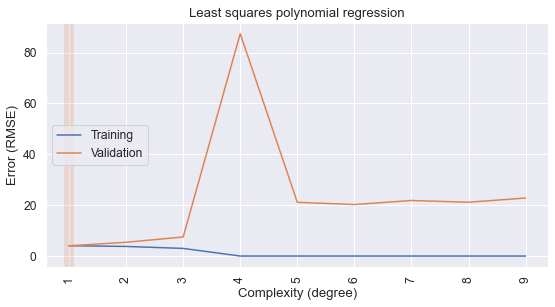

Optimal degree: 1


In [501]:
plot_fitting_graph(Deg, rmse_hwtrain, rmse_hwvalid, 
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

print(f'Optimal degree: {Deg[np.argmin(rmse_hwvalid)]}')

From plot we found the least optimal degree is 4. Investigate L1 and L2 using polinomial features with degree 4

 - without scaling:

In [502]:
X_hwpol = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X=X_hw)

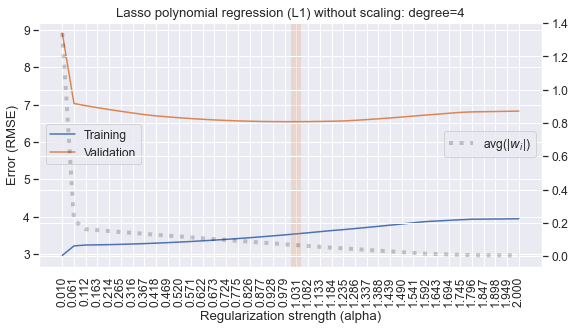

In [503]:
import warnings
warnings.filterwarnings('ignore')

rmse_hwtrain_l1, rmse_hwvalid_l1, avg_hwcoef_l1 = [], [], []
Alpas = np.linspace(0.01, 2, 1 + 39)
for alpha in Alpas:    
    results = cross_validate(Lasso(alpha=alpha), 
                             X_hwpol, y_hw, cv=3,
                             scoring=('neg_root_mean_squared_error', 'r2'),
                             return_train_score=True, return_estimator=True,)
    rmse_hwtrain_l1.append(-np.mean(results['train_neg_root_mean_squared_error']))
    rmse_hwvalid_l1.append(-np.mean(results['test_neg_root_mean_squared_error']))
    avg_hwcoef_l1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))   
            
plot_fitting_graph(Alpas, rmse_hwtrain_l1, rmse_hwvalid_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_hwcoef_l1, custom_label='avg(|$w_i$|)', custom_scale='linear',
                   title='Lasso polynomial regression (L1) without scaling: degree=4')


In [504]:
print(f'Optimal alpa for L1 regularization (no scaling): {Alpas[np.argmin(rmse_hwvalid_l1)]}\
\nMean error: {min(rmse_hwvalid_l1)}')

Optimal alpa for L1 regularization (no scaling): 1.0305128205128204
Mean error: 6.542915158776585


- with scaling:

In [505]:
X_nhwpol = PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=X_hw_new)

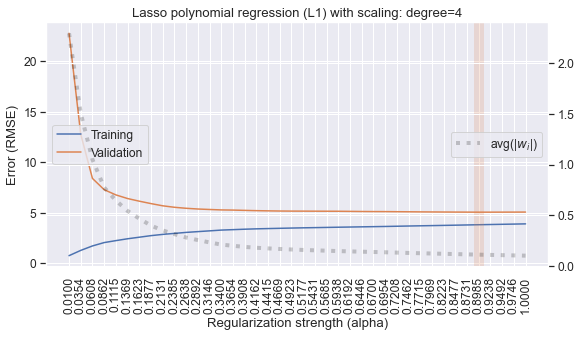

In [506]:
rmse_nhwtrain_l1, rmse_nhwvalid_l1, avg_nhwcoef_l1 = [], [], []
Alpas = np.linspace(0.01, 1, 1 + 39)
for alpha in Alpas:    
    results = cross_validate(Lasso(alpha=alpha), 
                             X_nhwpol, y_hw, cv=3,
                             scoring=('neg_root_mean_squared_error', 'r2'),
                             return_train_score=True, return_estimator=True,)
    rmse_nhwtrain_l1.append(-np.mean(results['train_neg_root_mean_squared_error']))
    rmse_nhwvalid_l1.append(-np.mean(results['test_neg_root_mean_squared_error']))
    avg_nhwcoef_l1.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))   
            
plot_fitting_graph(Alpas, rmse_nhwtrain_l1, rmse_nhwvalid_l1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_nhwcoef_l1, custom_label='avg(|$w_i$|)', custom_scale='linear',
                   title='Lasso polynomial regression (L1) with scaling: degree=4')


In [507]:
print(f'Optimal alpa for L1 regularization (with scaling): {Alpas[np.argmin(rmse_nhwvalid_l1)]}\
\nMean error: {min(rmse_nhwvalid_l1)}')

Optimal alpa for L1 regularization (with scaling): 0.8984615384615384
Mean error: 5.068415486105567


We can see that features scaling helps go gain optimal alpa that is smaler.

#### L2

- without scaling

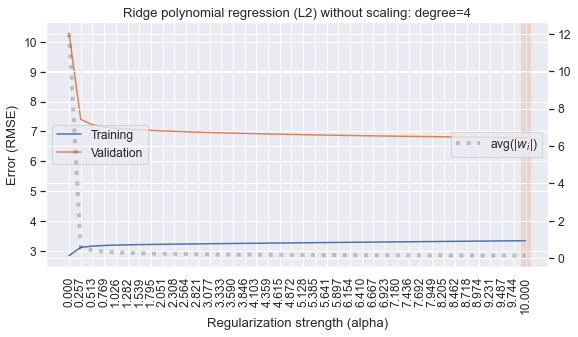

In [508]:
rmse_hwtrain_l2, rmse_hwvalid_l2, avg_hwcoef_l2 = [], [], []
Alpas = np.linspace(0.0001, 10, 1 + 39)
for alpha in Alpas:    
    results = cross_validate(Ridge(alpha=alpha), 
                             X_hwpol, y_hw, cv=3,
                             scoring=('neg_root_mean_squared_error', 'r2'),
                             return_train_score=True, return_estimator=True,)
    rmse_hwtrain_l2.append(-np.mean(results['train_neg_root_mean_squared_error']))
    rmse_hwvalid_l2.append(-np.mean(results['test_neg_root_mean_squared_error']))
    avg_hwcoef_l2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))   
            
plot_fitting_graph(Alpas, rmse_hwtrain_l2, rmse_hwvalid_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_hwcoef_l2, custom_label='avg(|$w_i$|)', custom_scale='linear',
                   title='Ridge polynomial regression (L2) without scaling: degree=4')


In [509]:
print(f'Optimal alpa for L2 regularization (no scaling): {Alpas[np.argmin(rmse_hwvalid_l2)]}\
\nMean error: {min(rmse_hwvalid_l2)}')

Optimal alpa for L2 regularization (no scaling): 10.0
Mean error: 6.788248895757438


- with scaling:

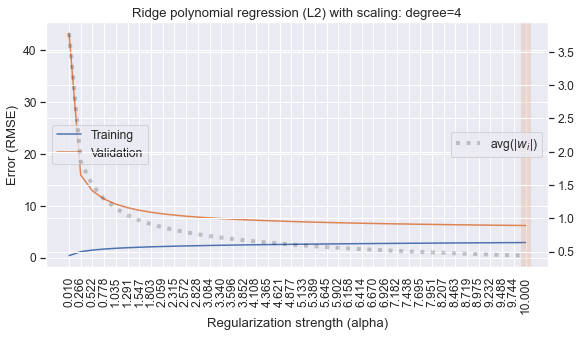

In [510]:
rmse_nhwtrain_l2, rmse_nhwvalid_l2, avg_nhwcoef_l2 = [], [], []
Alpas = np.linspace(0.01, 10, 1 + 39)
for alpha in Alpas:    
    results = cross_validate(Ridge(alpha=alpha), 
                             X_nhwpol, y_hw, cv=3,
                             scoring=('neg_root_mean_squared_error', 'r2'),
                             return_train_score=True, return_estimator=True,)
    rmse_nhwtrain_l2.append(-np.mean(results['train_neg_root_mean_squared_error']))
    rmse_nhwvalid_l2.append(-np.mean(results['test_neg_root_mean_squared_error']))
    avg_nhwcoef_l2.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model.coef_))
            for model in results['estimator']
        ]))   
            
plot_fitting_graph(Alpas, rmse_nhwtrain_l2, rmse_nhwvalid_l2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_nhwcoef_l2, custom_label='avg(|$w_i$|)', custom_scale='linear',
                   title='Ridge polynomial regression (L2) with scaling: degree=4')


In [511]:
print(f'Optimal alpa for L1 regularization (with scaling): {Alpas[np.argmin(rmse_nhwvalid_l2)]}\
\nMean error: {min(rmse_nhwvalid_l2)}')

Optimal alpa for L1 regularization (with scaling): 10.0
Mean error: 6.17569590397457


Let's look at coefficients:

In [512]:
pd.DataFrame({'Alpa': [Alpas[np.argmin(rmse_hwvalid_l1)], Alpas[np.argmin(rmse_hwvalid_l2)],\
                       Alpas[np.argmin(rmse_nhwvalid_l1)], Alpas[np.argmin(rmse_nhwvalid_l2)]], 
              'RMSE' : [min(rmse_hwvalid_l1), min(rmse_hwvalid_l2), min(rmse_nhwvalid_l1), min(rmse_nhwvalid_l2)], 
              'Average coefficient' : [avg_coef_l1[np.argmin(rmse_hwvalid_l1)], avg_coef_l2[np.argmin(rmse_hwvalid_l2)],\
                                       avg_coef_l1[np.argmin(rmse_nhwvalid_l1)], avg_coef_l2[np.argmin(rmse_nhwvalid_l2)]]},
            index = ['L1', 'L2', 'L1cs','L2cs'])

,Alpa,RMSE,Average coefficient
L1,5.133077,6.542915,0.504332
L2,10.000000,6.788249,0.612488
L1cs,8.975385,5.068415,0.472604
L2cs,10.000000,6.175696,0.612488


#### Summary



 - Scaling features in common make better performance for model regularization.
 - Empirically RMSE become better borh for L1 and L2 regularization with scaling features
 - Empirically L1 reglarization with scaling features shows better changing in RMSE and coefficients. RMSE decreased twice. Average coefficient decreased lightly.  
 - Empirically L2 reglarization with scaling features shows weak changing in RMSE. It changed lightly and become less. Average coefficient remain the same.
 - Actually we didn't reach optimal L2 regularization on choosen range of alpa. Optimal line is at the end of X_scale. RMSE valid contimue decreases, while RMSE train increases. Perhaps, alpa range should be increased or another parameters should be observed.  